# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import os
import imageio
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [ ]:
!nvidia-smi

Sat Jul 31 16:34:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:1A:00.0 Off |                  Off |
| 30%   47C    P8    15W / 300W |  15472MiB / 48685MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
train= np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val= np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

In [ ]:
train.shape

(663,)

In [ ]:
batch_size=50
img_height = 84
img_width = 84

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = range(0,30,2) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                  
                  #crop the images and resize them. Note that the images are of 2 different shape 
                  #and the conv3D will throw error if the inputs in a batch have different shapes
                  img= tf.image.resize(image, [img_height,img_width])/255
                  batch_data[folder,idx,:,:,0] = img[:,:,0]
                  batch_data[folder,idx,:,:,1] = img[:,:,1]
                  batch_data[folder,idx,:,:,2] = img[:,:,2]
                      
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        if(len(t)%batch_size!=0):          
          batch = num_batches
          new_seq=len(t)%batch_size          
          batch_data = np.zeros((new_seq,len(img_idx),img_height,img_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
          batch_labels = np.zeros((new_seq,5)) # batch_labels is the one hot representation of the output
          for folder in range(new_seq): # iterate over the batch_size
              imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
              for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                #crop the images and resize them. Note that the images are of 2 different shape 
                #and the conv3D will throw error if the inputs in a batch have different shapes
                img= tf.image.resize(image, [img_height,img_width])/255
                batch_data[folder,idx,:,:,0] = img[:,:,0]
                batch_data[folder,idx,:,:,1] = img[:,:,1]
                batch_data[folder,idx,:,:,2] = img[:,:,2]
                    
              batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
          yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
      
      
      


#### Visualizing the Generator processed batch of images.

In [ ]:
a=generator("/datasets/Project_data/train",train,batch_size)
data,label=next(a)


Source path =  /datasets/Project_data/train ; batch size = 50


In [ ]:
class_names = ['Left_Swipe', 'Right_Swipe', 'Stop','Thumbs_Down','Thumbs_Up']
def show_random_examples(x, y, p):
    plt.figure(figsize=(30, batch_size/2))
    for i in range(batch_size):      
      plt.subplot((batch_size/10)+1, 10, 1 + i)
      plt. imshow(data[i][5])  
      plt.xticks([])
      plt.yticks([])   
      col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
      plt.xlabel(class_names[np.argmax(p[i])], color = col)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


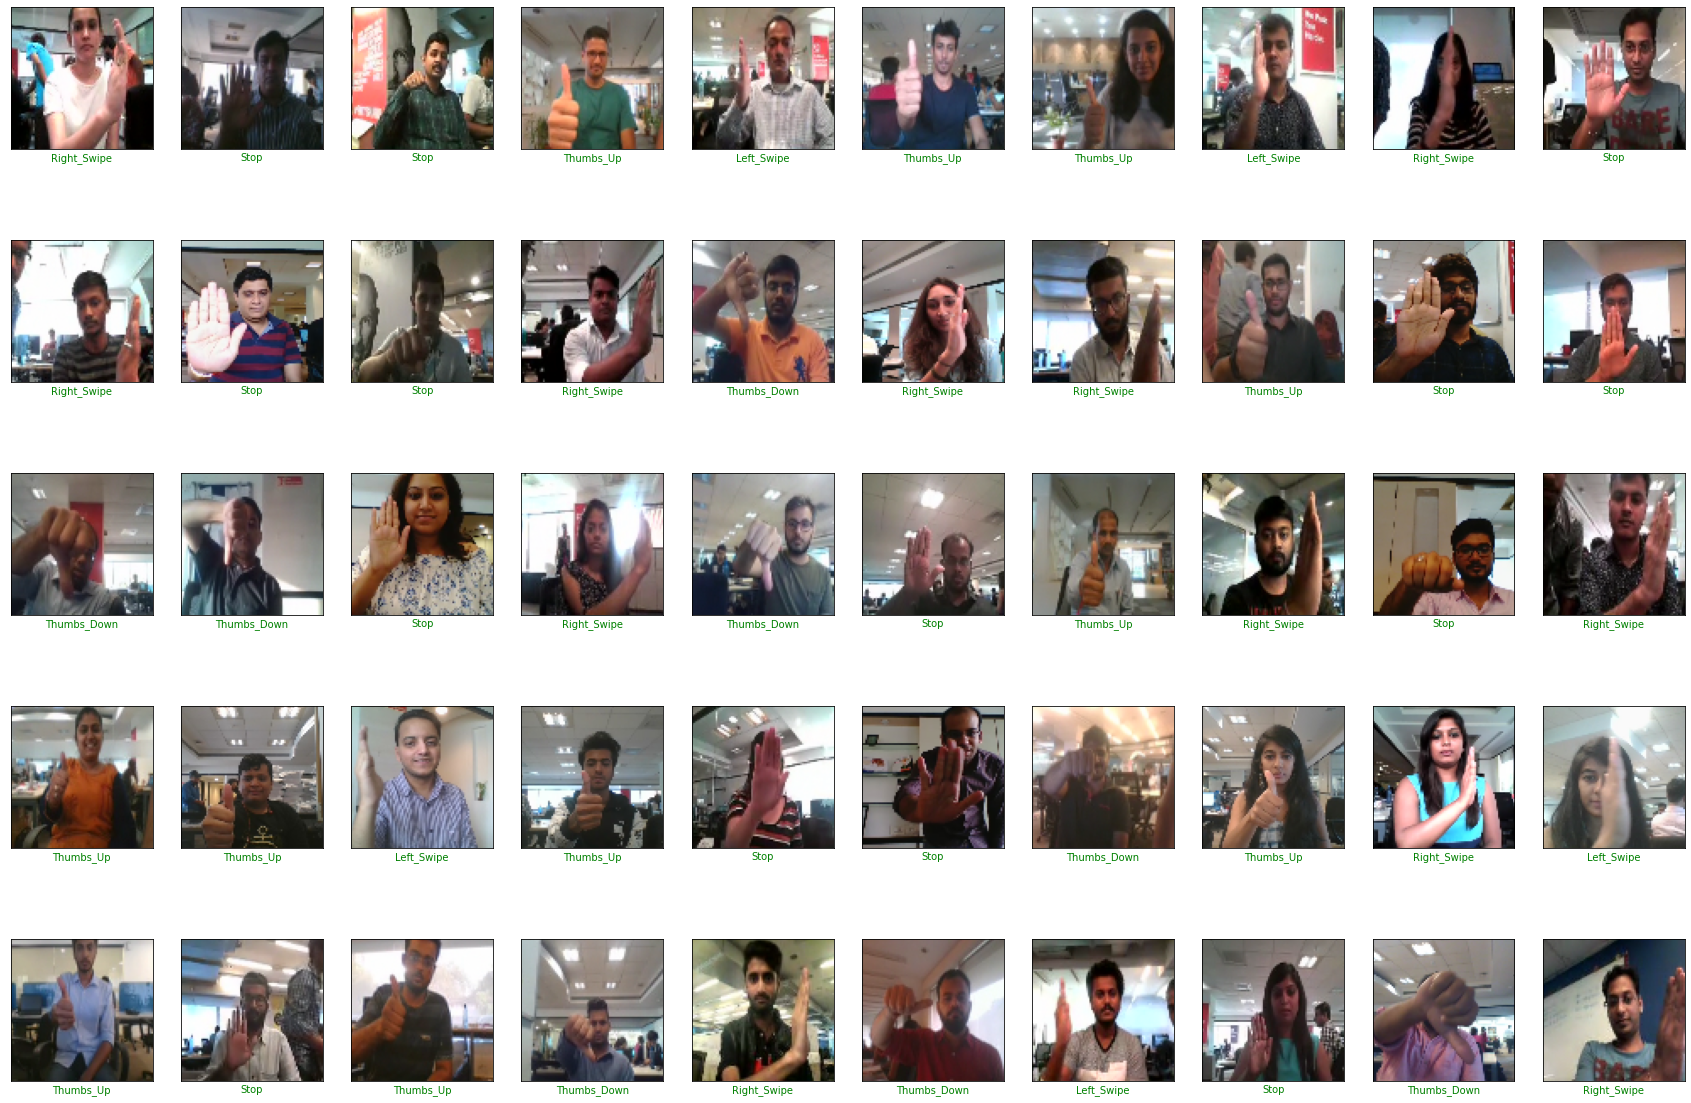

In [ ]:
show_random_examples(data, label, label)

In [ ]:
data.shape

(50, 15, 84, 84, 3)

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/datasets/Project_data/train'
val_path = '/datasets/Project_data/val'
num_train_sequences = len(train)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)
num_frames = 15
print ('# frames =', num_frames)

# training sequences = 663
# validation sequences = 100
# epochs = 10
# frames = 15


# Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1: Conv2D + RNN with Transfer Learning - MobileNet

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Input,Dropout, ConvLSTM2D
from tensorflow.keras.layers import Conv3D, MaxPooling3D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomRotation,RandomZoom

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train, batch_size)
val_generator = generator(val_path, val, batch_size)

In [ ]:
model_name = 'Models/model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=10,verbose=0,mode="auto",min_delta=0.0001,cooldown=0,min_lr=0)
eStop = EarlyStopping(monitor = 'val_categorical_accuracy', patience=3),
callbacks_list = [checkpoint, eStop,LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%30) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
steps_per_epoch

14

In [ ]:
from tensorflow.keras.applications import MobileNet

In [ ]:
base_model=MobileNet(weights='imagenet',include_top=False, input_shape=(img_height,img_width,3))


layer1 = base_model.output 
layer2 = GlobalAveragePooling2D(name='avg_pool')(layer1) #1024
#layer2 = Dropout(0.4)(layer2)
predictions = Dense(64, activation='relu')(layer2)
my_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(TimeDistributed(my_model, input_shape=(15,img_height,img_width,3)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(16))
#model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
adm =  optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 15, 64)            3294464   
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 32)            9408      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 45        
Total params: 3,306,453
Trainable params: 77,589
Non-trainable params: 3,228,864
_________________________________________________________________
None


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /datasets/Project_data/train ; batch size = 50
Epoch 1/10
14/14 [==============================] - ETA: 0s - loss: 1.6502 - categorical_accuracy: 0.2172Source path =  /datasets/Project_data/val ; batch size = 50

Epoch 00001: saving model to Models/model_init_2021-07-3116_36_29.838489/model-00001-1.65017-0.21719-1.58990-0.25333.h5
14/14 [==============================] - 57s 4s/step - loss: 1.6502 - categorical_accuracy: 0.2172 - val_loss: 1.5899 - val_categorical_accuracy: 0.2533
Epoch 2/10
14/14 [==============================] - ETA: 0s - loss: 1.5308 - categorical_accuracy: 0.3077
Epoch 00002: saving model to Models/model_init_2021-07-3116_36_29.838489/model-00002-1.53077-0.30769-1.48860-0.31333.h5
14/14 [==============================] - 55s 4s/step - loss: 1.5308 - categorical_accuracy: 0.3077 - val_loss: 1.4886 - val_categorical_accuracy: 0.3133
Epoch 3/10
14/14 [==============================] - ETA: 0s - loss: 1.4605 - categorical_accuracy: 0.3891
Epoch 00003: s

#### Checking Categorical and Validation Accuracy.

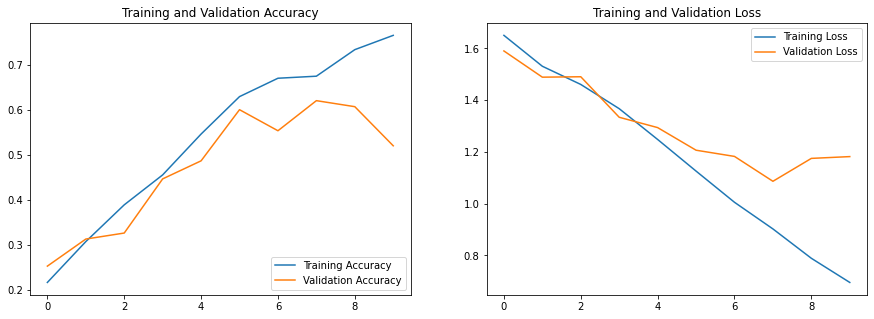

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Testing the model against validation set (optional)

In [ ]:
model = tf.keras.models.load_model('Models/model_init_2021-07-3116_36_29.838489/model-00008-0.90225-0.67421-1.08631-0.62000.h5')

In [ ]:
a=generator("/datasets/Project_data/val",val,batch_size)
data,label=next(a)


Source path =  /datasets/Project_data/val ; batch size = 50


In [ ]:
pred_batch=model.predict(data/.255)

In [ ]:
pred_batch[pred_batch > 0.5] = 1
pred_batch[pred_batch <= 0.5] = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


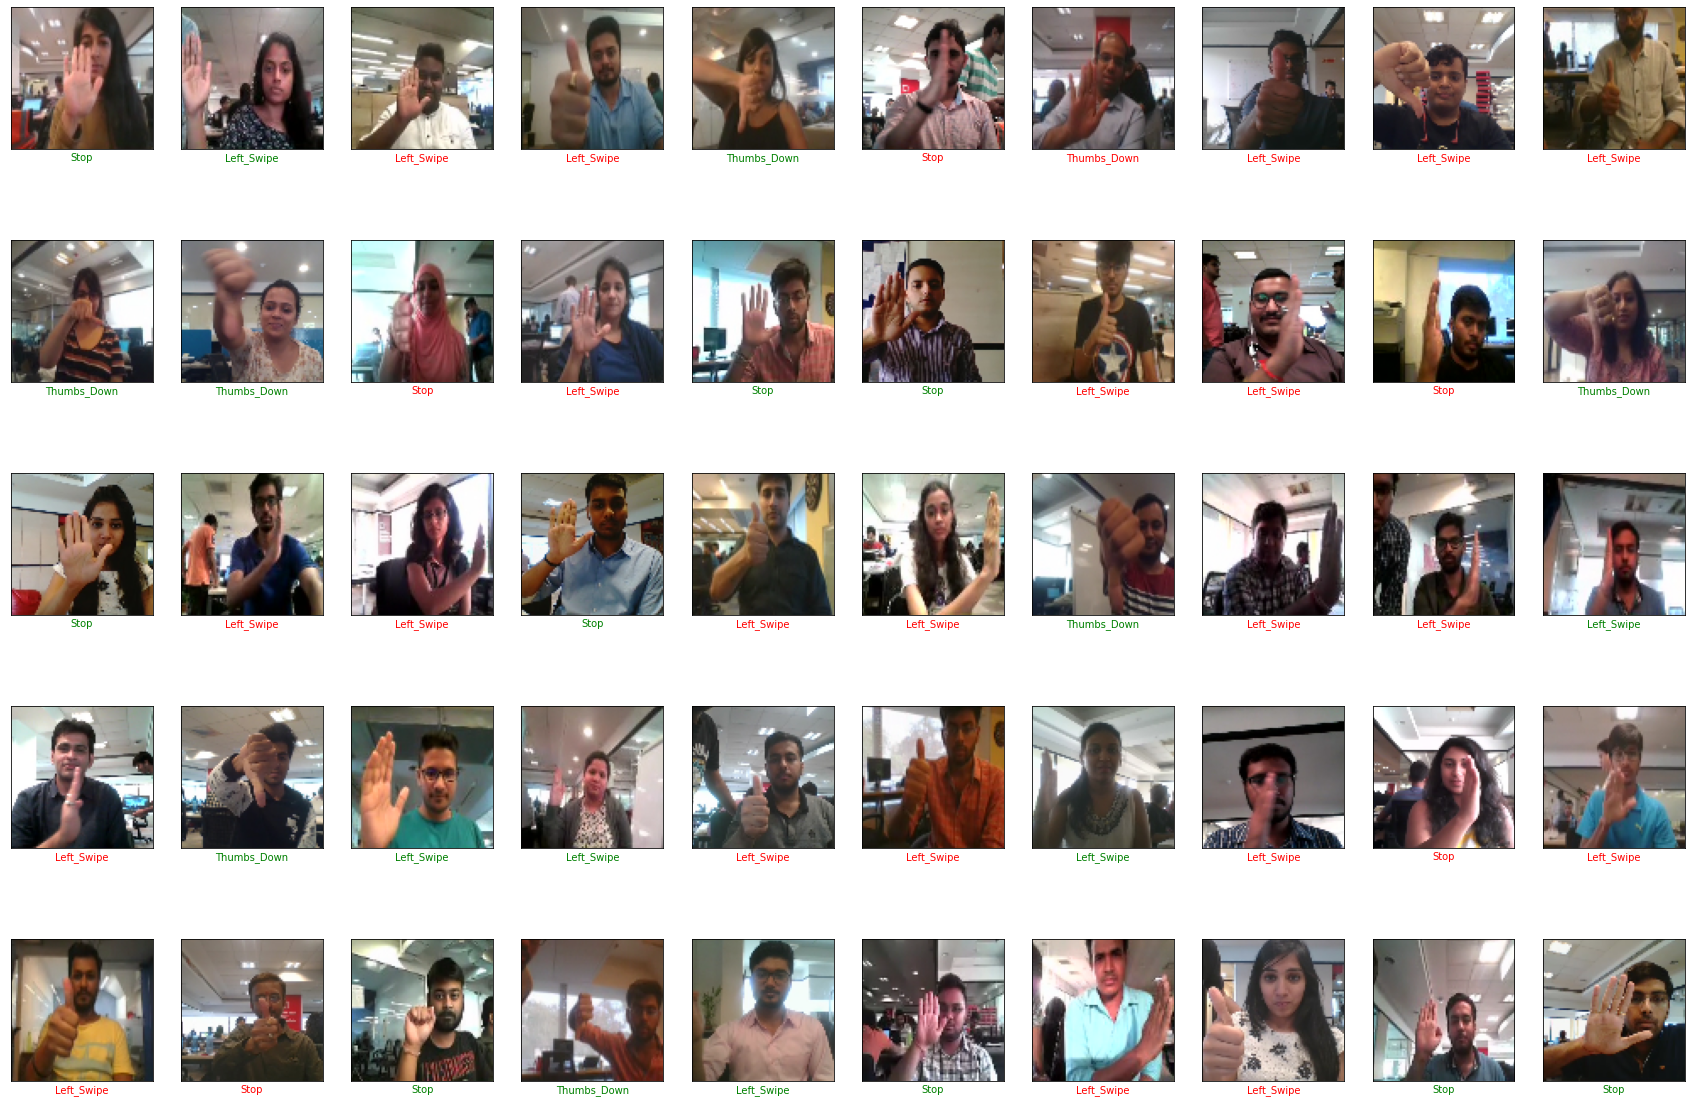

In [ ]:
show_random_examples(data, label, pred_batch)

## Model 2 : using Conv3D and MaxPooling 3D

Creating model using Conv3D and MaxPooling 3D.
After you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.001, beta_1=0.7, beta_2=0.7)
def create_model():
  def add_conv3d_block(model,num_filters):
    model.add(Conv3D(num_filters,kernel_size=(3,3,2), activation='elu',padding='same'))    
    model.add(MaxPooling3D(pool_size=(2,2,2)))
    model.add(Dropout(0.5))
    return model
  model = Sequential()
  model.add(Input(shape=(num_frames,img_height,img_width,3)))
  
#   model = add_conv3d_block(model,32)
  model = add_conv3d_block(model,64)
  model = add_conv3d_block(model,128)
  model = add_conv3d_block(model,256)
#   model.add(GlobalAveragePooling2D())
  model.add(ConvLSTM2D(20, (3, 3)))

  model.add(Flatten())
  model.add(Dense(5, activation = 'softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 84, 84, 64)    3520      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 42, 42, 64)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 42, 42, 64)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 42, 42, 128)    147584    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 21, 21, 128)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 21, 21, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 21, 21, 256)   

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
14/14 [==============================] - ETA: 0s - loss: 1.6284 - categorical_accuracy: 0.2308
Epoch 00001: saving model to Models/model_init_2021-07-3116_36_29.838489/model-00001-1.62837-0.23077-1.60689-0.20000.h5
14/14 [==============================] - 61s 4s/step - loss: 1.6284 - categorical_accuracy: 0.2308 - val_loss: 1.6069 - val_categorical_accuracy: 0.2000
Epoch 2/20
14/14 [==============================] - ETA: 0s - loss: 1.5166 - categorical_accuracy: 0.3107
Epoch 00002: saving model to Models/model_init_2021-07-3116_36_29.838489/model-00002-1.51664-0.31071-1.56521-0.31333.h5
14/14 [==============================] - 59s 4s/step - loss: 1.5166 - categorical_accuracy: 0.3107 - val_loss: 1.5652 - val_categorical_accuracy: 0.3133
Epoch 3/20
14/14 [==============================] - ETA: 0s - loss: 1.2824 - categorical_accuracy: 0.4736
Epoch 00003: saving model to Models/model_init_2021-07-3116_36_29.838489/model-00003-1.28238-0.47360-1.33557-0.41333.h5
14/14 [=========

#### Checking Categorical and Validation Accuracy.

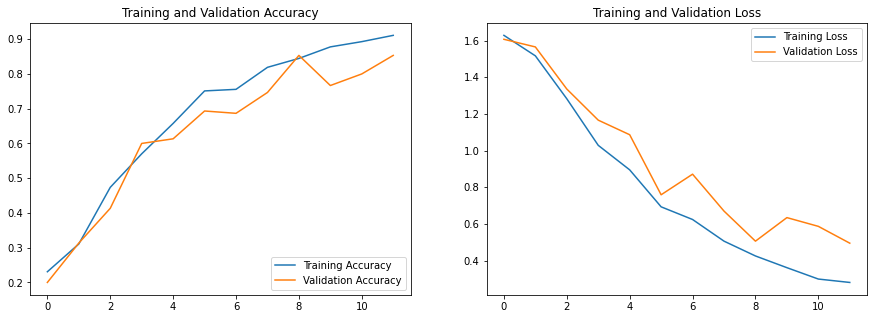

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Testing the model against validation set.

In [ ]:
model = tf.keras.models.load_model('Models/model_init_2021-07-3116_36_29.838489/model-00011-0.29882-0.89291-0.58634-0.80000.h5')

In [ ]:
a=generator("/datasets/Project_data/val",val,batch_size)
data,label=next(a)


Source path =  /datasets/Project_data/val ; batch size = 50


In [ ]:
pred_batch=model.predict(data/.255)

In [ ]:
pred_batch[pred_batch > 0.5] = 1
pred_batch[pred_batch <= 0.5] = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  """


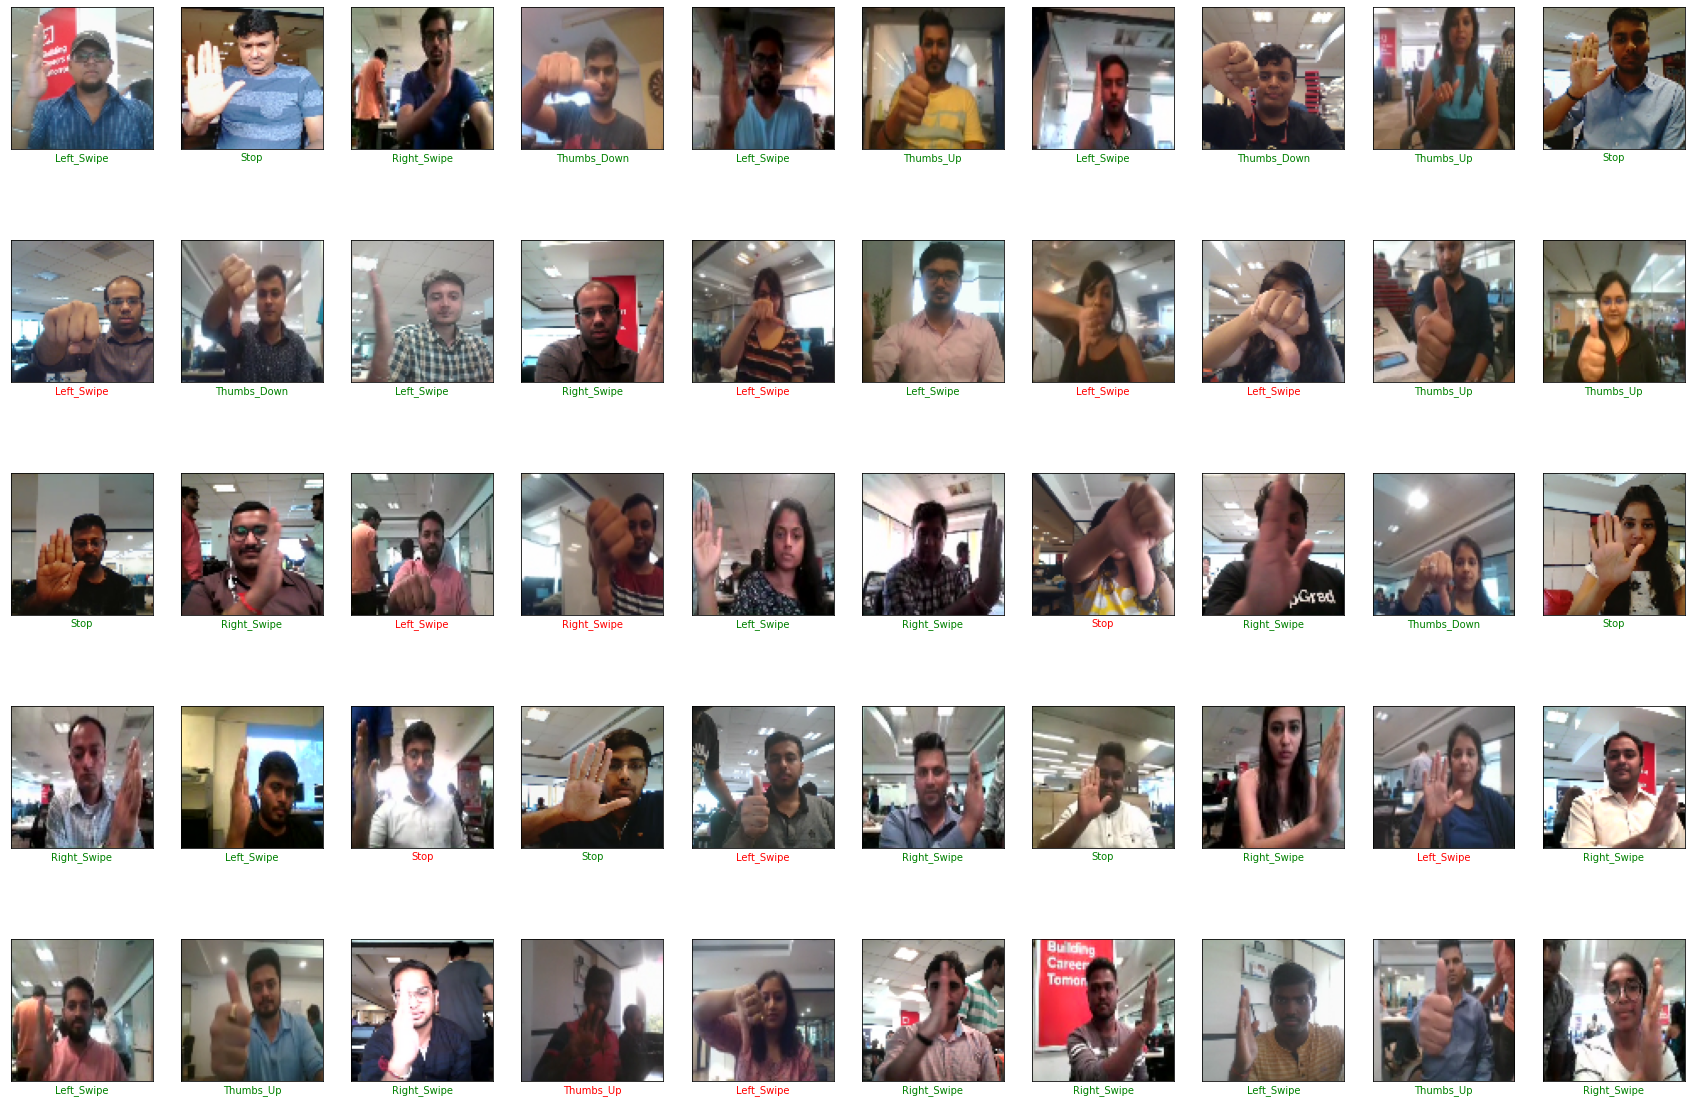

In [ ]:
show_random_examples(data, label, pred_batch)